# Logistic Loss And Convexity
## Chris Tralie

The purpose of this notebook is to explore a very simple pathological case where logistic regression can get stuck in a local min if we don't use a convex loss function

In [1]:
import numpy as np
import matplotlib.pyplot as plt

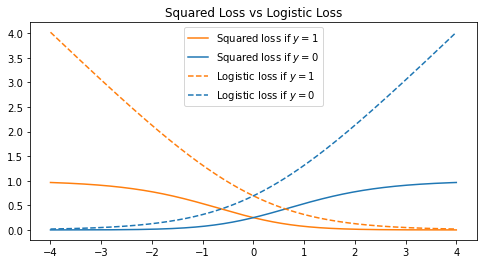

In [2]:
logistic = lambda u: 1/(1+np.exp(-u))
u = np.linspace(-4, 4, 1000)
plt.figure(figsize=(8, 4))
plt.plot(u, (1-logistic(u))**2, c='C1')
plt.plot(u, logistic(u)**2, c='C0')
plt.plot(u, -np.log(logistic(u)), c='C1', linestyle='--')
plt.plot(u, -np.log(1-logistic(u)), c='C0', linestyle='--')
plt.legend(["Squared loss if $y = 1$", "Squared loss if $y = 0$", 
            "Logistic loss if $y = 1$", "Logistic loss if $y = 0$"])
plt.title("Squared Loss vs Logistic Loss")
plt.savefig("SquaredVsLogisticLoss.svg", bbox_inches='tight')

In [3]:
def get_squared_loss(x, y, a, b):
    """
    Compute the squared loss (non convex!)

    Parameters
    ----------
    x: ndarray(N)
        X coordinates of the data points
    y: ndarray(N)
        Class labels of the data points
    a, b: float, float
        Logistic regression parameters
    """
    f = logistic(a*x+b)
    return np.sum((f-y)**2)

def get_logistic_loss(x, y, a, b):
    """
    Compute the logistic loss

    Parameters
    ----------
    x: ndarray(N)
        X coordinates of the data points
    y: ndarray(N)
        Class labels of the data points
    a, b: float, float
        Logistic regression parameters
    """
    f = logistic(a*x+b)
    return np.sum(-y*np.log(f) - (1-y)*np.log(1-f))


def plot_logistic_regression_predictions(x, y, a, b, lossfn):
    """
    Plot the current logistic function estimate against the points,
    and show which points were correctly classified
    
    Parameters
    ----------
    x: ndarray(N)
        X coordinates of the data points
    y: ndarray(N)
        Class labels of the data points
    a, b: float, float
        Logistic regression parameters
    lossfn: function (x, y, a, b) -> float
        Loss function to use
    """
    loss = lossfn(x, y, a, b)
    x0 = x[y == 0]
    x1 = x[y == 1]
    plt.scatter(x0, np.zeros(x0.size))
    plt.scatter(x1, np.ones(x1.size))
    xx = np.linspace(np.min(x)-0.1, np.max(x)+0.1)
    plt.plot(xx, logistic(a*xx + b))
    plt.plot(xx, 0.5*np.ones(xx.size), c='k', linestyle='--')
    wrong = 0
    for x in x0:
        y = logistic(a*x + b)
        plt.plot([x, x], [0, y], c='C0')
        if y > 0.5:
            plt.scatter([x], [0], 200, c='C0', marker='x')
            wrong += 1
    for x in x1:
        y = logistic(a*x + b)
        plt.plot([x, x], [1, y], c='C1')
        if y < 0.5:
            plt.scatter([x], [1], 200, c='C1', marker='x')
            wrong += 1
    N = x0.size + x1.size
    plt.title("Loss = {:.3f}, {} Wrong ({} % Accuracy)".format(loss, wrong, int(100*(N-wrong)/N)))


def plot_logistic_neighborhood(x, y, lossfn, amin, amax, bmin, bmax, res=50):
    """
    Plot a neighborhood of the logistic function
    evaluated on a set of points
    
    Parameters
    ----------
    x: ndarray(N)
        X coordinates of the data points
    y: ndarray(N)
        Class labels of the data points
    lossfn: function (x, y, a, b) -> float
        Loss function to use
    amin, amax, bmin, bmax
        Neighborhood around which to display values
    res: int
        Resolution to search around (a, b)
    """
    aa = np.linspace(amin, amax, res)
    bb = np.linspace(bmin, bmax, res)
    aa, bb = np.meshgrid(aa, bb)
    I = np.zeros_like(aa)
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            I[i, j] = lossfn(x, y, aa[i, j], bb[i, j])
    plt.imshow(I, cmap='magma', extent=(amin, amax, bmax, bmin), aspect='auto')
    plt.xlabel("a")
    plt.ylabel("b")
    plt.colorbar()
    plt.gca().invert_yaxis()

Showing an example with only 4 data points that's nonconvex with squared loss

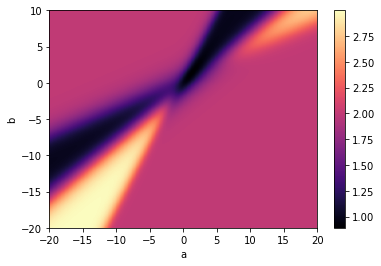

In [4]:
N = 100
x0 = np.array([-1.8, -0.4])
x1 = np.array([-0.7, -0.8])
x = np.concatenate((x0, x1))
y = np.concatenate((np.zeros(x0.size), np.ones(x1.size)))
plt.clf()
a1 = -20
a2 = 20
b1 = -20
b2 = 10
plot_logistic_neighborhood(x, y, get_squared_loss, a1, a2, b1, b2, res=200)

Do an animation of gradient descent, changing the initial point and the loss function used

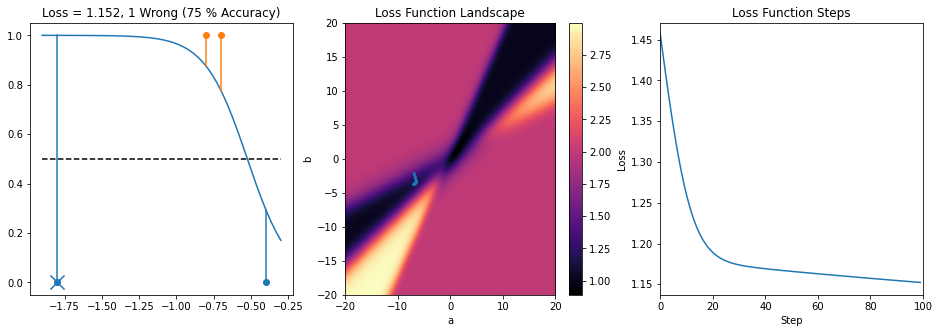

In [5]:
do_animation = False # If False, just show the last frame
use_logistic_loss = False
loss_fn = get_logistic_loss
if not use_logistic_loss:
    loss_fn = get_squared_loss
## Initial point
a = -7; b = -2
#a = 0; b = 0
    
    
losses = []
steps = []
alpha = 0.5
n_iters = 100

plt.figure(figsize=(16, 5))
plot_num = 0
for it in range(n_iters):
    f = logistic(a*x + b)
    
    if use_logistic_loss:
        # Update rules for logistic loss
        a += alpha*np.sum((y-f)*x)
        b += alpha*np.sum(y-f)
    else:
        # Update rules for squared loss
        a += alpha*(np.sum((y-f)*f*(1-f)*x))
        b += alpha*(np.sum((y-f)*f*(1-f)))

    steps.append([a, b])
    loss = loss_fn(x, y, a, b)
    losses.append(loss)
    
    if do_animation or it == n_iters-1:
        plt.clf()
        plt.subplot(131)
        plot_logistic_regression_predictions(x, y, a, b, loss_fn)
        plt.subplot(132)
        plot_logistic_neighborhood(x, y, loss_fn, -20, 20, -20, 20, res=200)
        plt.plot(np.array(steps)[:, 0], np.array(steps)[:, 1])
        plt.scatter(np.array(steps)[:, 0], np.array(steps)[:, 1], 1)
        plt.title("Loss Function Landscape")
        plt.subplot(133)
        plt.plot(losses)
        plt.title("Loss Function Steps")
        plt.xlabel("Step")
        plt.ylabel("Loss")
        plt.xlim([0, n_iters])
        plt.savefig("Iter{}.png".format(plot_num), facecolor='white', bbox_inches='tight')
        plot_num += 1